Raoul Island Lake Monitoring Data - Calculation and Presentation of Daily Mean Data
--

At Raoul Island, the temperature and level of Green Lake and the temperature of Marker Bay pool are measured. Measurements are digitised with a Quanterra Q330 at a sample rate of 1 sample per second. For plotting and examination of these data over time periods of several years, a sample rate of 1 sample per second is too high for the slowly changing temperatures and lake level.

The raw data are stored as mini-seed files as part of GeoNet's seismic data archive. These data can be accessed using GeoNet's FDSN web servers http://www.geonet.org.nz/data/tools/FDSN. Response information can be retrieved with the raw data, which allows raw observations to be converted to units of degrees celcius and metres, respectively.

Running this python notebook will first update the daily mean data files (if required), and then make long-term plots of the data. The daily mean files are stored on disk (as CSV files) and can be copied for use elsewhere.

If a waveform data file is unavailable, or cannot be read, the 'value' and 'error' for that day will be set to NaN (https://en.wikipedia.org/wiki/NaN). This means that data plots will automatically 'break' at that point.

Plots show:
- daily mean data as a solid line
- +/- two standard deviations around the mean temperature as a semi-opaque band

Plots use somewhat 'cleaned' data, so that they look relatively 'nice', but no attempt has been made to produce a completely 'clean' dataset.

For short-term changes, the Platform team provides frequently updating plots using the full 1 sample per second data. These plots are available on the GeoNet wiki:
- http://images.geonet.org.nz/volcano/ki/glkz/40/drum.png
- http://images.geonet.org.nz/volcano/ki/glkz/80/drum.png
- http://images.geonet.org.nz/volcano/ki/glkz/81/drum.png.

Because of the way GeoNet's FDSN web servers are set up http://www.geonet.org.nz/data/tools/FDSN, this script does not create daily mean data upto the current day, but stops 10 days ago.

In [1]:
from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client

import pandas as pd

%matplotlib inline

In [2]:
#fdsn client
client = Client("http://service.geonet.org.nz")
#this client contains only data 8 days old and older, see http://www.geonet.org.nz/data/tools/FDSN

In [3]:
def daywave(date, net, sta, loc, cmp):
  global st
  time = UTCDateTime(date)
  st = client.get_waveforms(net, sta, loc, cmp, time, time + 86400, attach_response=True)

In [4]:
#channel data for fdsn
net = 'NZ'
sta = 'GLKZ'

In [5]:
#get data upto how many days before now
ndays = 10

In [6]:
#channel specific parameters
chan = [{'loc':'80', 'cmp':'LKO', 'fname':'glt.csv', 'subject':'green lake temperature'},
        {'loc':'81', 'cmp':'LKO', 'fname':'mbt.csv', 'subject':'marker bay temperature'},
        {'loc':'40', 'cmp':'LTH', 'fname':'gll.csv', 'subject':'green lake level'}]

In [7]:
#column names
names = ['date', 'value', 'error']

Update daily average data
--

Loop through each channel:
- read the existing data from a CSV file
- find out which data need to be processed
- process the new data, calculating a daily mean value and standard deviation (error)
- append the new data to the existing
- write a new CSV file

In [8]:
for ch in chan:   
    #set variables
    cmp = ch['cmp']
    fname = ch['fname']
    loc = ch['loc']
    subject = ch['subject']
    print fname, cmp, loc, subject
    #read in existing data
    df = pd.read_csv(fname, parse_dates=True, names=names, index_col=0, skiprows=1)#, infer_datetime_format=True)
    
    #find first date to process
    dt1 = df.index[-1] + pd.to_timedelta(1, unit='D')
    dt1str = dt1.strftime('%Y-%m-%d')
    print 'first date to process '+dt1str
        
    #find last date to process
    dt2 = UTCDateTime() - (ndays * 86400)
    dt2str = dt2.date.strftime('%Y-%m-%d')
    print 'last date to process '+dt2str
          
    for date in pd.date_range(start=dt1str, end=dt2str, freq='D'):
        try:
            daywave(date, net, sta, loc, cmp)
            st.remove_sensitivity()
            st.merge(fill_value = 'interpolate')
            tr = st[0]
            mean = tr.data.mean()
            std = tr.data.std()
        except:
            print date.date(), 'retrieve unsuccessful'
            mean = float('nan')
            std = float('nan')
        print date.date(), mean, std
        vals = {'date':date.date(), 'value':mean, 'error':std}
        vals = {'value':mean, 'error':std}
        newrow = pd.DataFrame([vals], columns=vals.keys(), index={pd.to_datetime(date.date())})
        df = df.append(newrow, ignore_index=False)
    
    df.to_csv(fname, columns=['value', 'error'], na_rep='NaN', index=True)
    
    print

glt.csv LKO 80 green lake temperature
first date to process 2017-12-31
last date to process 2017-12-31
2017-12-31 24.5311674316 0.724637646173

mbt.csv LKO 81 marker bay temperature
first date to process 2017-12-31
last date to process 2017-12-31
2017-12-31 26.0285542081 0.232218781429

gll.csv LTH 40 green lake level
first date to process 2017-12-31
last date to process 2017-12-31
2017-12-31 1.10083485871 0.0150183319632



Plot the full data set
--

Make a combined temperature plot for Green Lake and Marker Bay.

Make a plots of the water depth above the sensor at Green Lake.

In [9]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [10]:
import matplotlib.pyplot as plt

**Green Lake and Marker Bay temperatures**

In [11]:
#read the upto date data
glt = pd.read_csv('glt.csv', parse_dates=True, index_col=0)
mbt = pd.read_csv('mbt.csv', parse_dates=True, index_col=0)

In [12]:
#some data are 'bad' remove these prior to plotting so that plots look 'nice'

#plot y-axis limits, adjust these if large (real) changes occur
ylim1 = 12
ylim2 = 35
errlim = 1

#replace values that are clearly not representative of the water temperature with NaN
#based on data value
#mbt
#error
mbt.loc[mbt.value < ylim1, 'error'] = float('nan')
mbt.loc[mbt.value > ylim2, 'error'] = float('nan')
#value
mbt.loc[mbt.value < ylim1, 'value'] = float('nan')
mbt.loc[mbt.value > ylim2, 'value'] = float('nan')
#glt
glt.loc[glt.value < ylim1, 'error'] = float('nan')
glt.loc[glt.value > ylim2, 'error'] = float('nan')
#value
glt.loc[glt.value < ylim1, 'value'] = float('nan')
glt.loc[glt.value > ylim2, 'value'] = float('nan')

#based on error value, only large values
#mbt
mbt.loc[mbt.error > errlim, 'error'] = float('nan')
mbt.loc[mbt.error > errlim, 'value'] = float('nan')
#glt
glt.loc[glt.error > errlim, 'error'] = float('nan')
glt.loc[glt.error > errlim, 'value'] = float('nan')

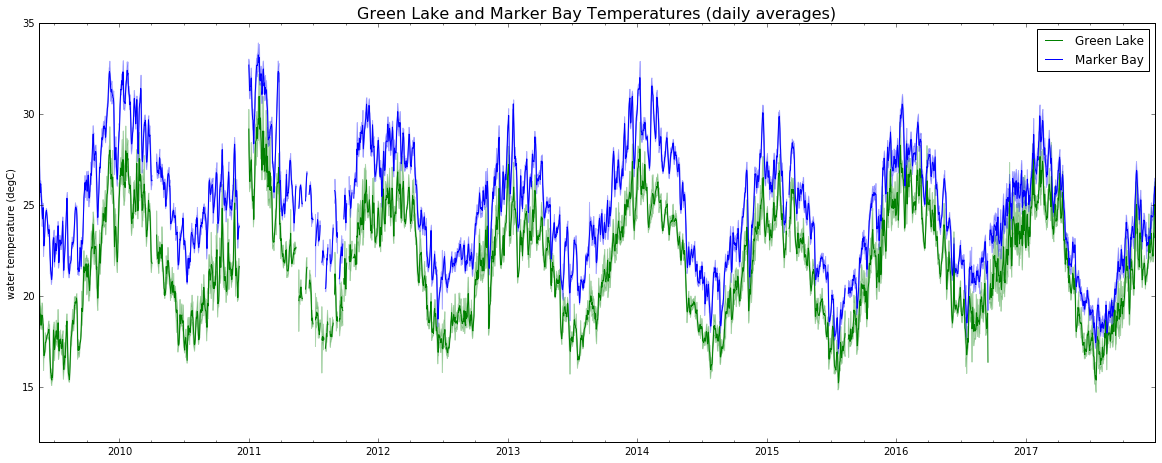

In [13]:
figsize=(20,7.5)
plt.figure()
temps = glt['value'].plot(label='Green Lake', color='green', figsize=figsize)
plt.fill_between(glt.index, glt.value-2*glt.error, glt.value+2*glt.error, color='green', alpha=0.3)
mbt['value'].plot(ax=temps, label='Marker Bay')
plt.fill_between(mbt.index, mbt.value-2*mbt.error, mbt.value+2*mbt.error, color='blue', alpha=0.3)
temps.legend(loc='best')
temps.set_ylabel('water temperature (degC)')
temps.set_title('Green Lake and Marker Bay Temperatures (daily averages)', fontsize=16)
temps.set_ylim(ylim1,ylim2)
plt.xlabel("") #get rid of useless 'date' label
plt.savefig('glt_mbt.png', dpi=100)

**Difference between Green Lake and Marker Bay temperatures**

Marker Bay is warmer than Green Lake, but the temperature difference has gradually reduced over time.

In [14]:
tdif = mbt['value'] - glt['value']

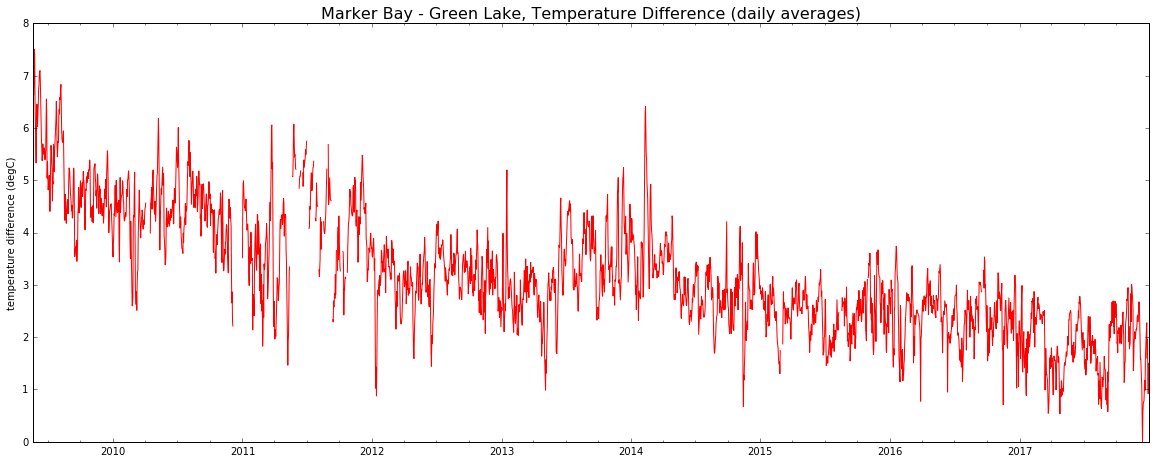

In [15]:
figsize=(20,7.5)
plt.figure()
dif = tdif.plot(color='red', figsize=figsize)
dif.set_ylabel('temperature difference (degC)')
dif.set_title('Marker Bay - Green Lake, Temperature Difference (daily averages)', fontsize=16)
plt.xlabel("") #get rid of useless 'date' label
plt.savefig('tdif.png', dpi=100)

**Green Lake level**

In [16]:
#read the upto date data
gll = pd.read_csv('gll.csv', parse_dates=True, index_col=0)

In [17]:
#some data are 'bad' remove these prior to plotting so that plots look 'nice'

#plot y-axis limits, adjust these if large (real) changes occur
ylim1 = 0.5
ylim2 = 3.5
errlim = 0.1

#replace values that are clearly not representative of the water depth with NaN
#green lake level data have some issues!
#error
gll.loc[gll.value < ylim1, 'error'] = float('nan')
gll.loc[gll.value > ylim2, 'error'] = float('nan')
#value
gll.loc[gll.value < ylim1, 'value'] = float('nan')
gll.loc[gll.value > ylim2, 'value'] = float('nan')

#based on error value, only large values
gll.loc[gll.error > errlim, 'error'] = float('nan')
gll.loc[gll.error > errlim, 'value'] = float('nan')

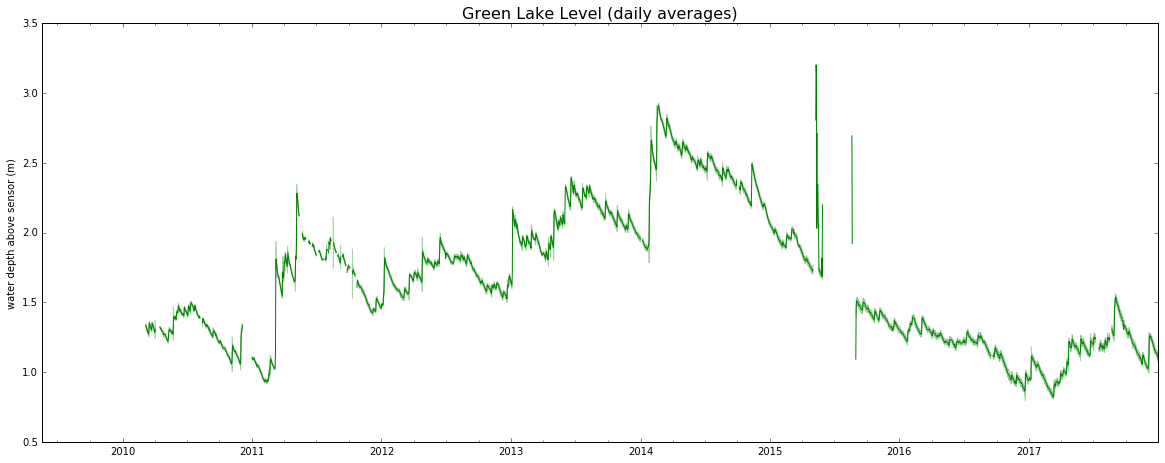

In [18]:
figsize=(20,7.5)
plt.figure()
level = gll['value'].plot(color='green', figsize=figsize)
plt.fill_between(gll.index, gll.value-2*gll.error, gll.value+2*gll.error, color='green', alpha=0.3)
level.set_ylabel('water depth above sensor (m)')
level.set_title('Green Lake Level (daily averages)', fontsize=16)
level.set_ylim(ylim1,ylim2)
plt.xlabel("") #get rid of useless 'date' label
plt.savefig('gll.png', dpi=100)